In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# KNN (k nearest neighbors)
---

The **k-nearest neighbors (KNN) algorithm** is a simple, **supervised** machine learning algorithm that can be used to solve both **classification and regression** problems. It’s **easy** to implement and understand, but has a major **drawback of becoming significantly slows** as the size of that data in use grows.

KNN works by finding the **distances** between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the **most frequent label** (in the case of **classification**) or **averages the labels** (in the case of **regression**).

### Algorithm
    1. Load the data
    2. Initialize K to your chosen number of neighbors
    3. For each example in the data
        3.1 Calculate the distance between the query example and the current example from the data.
        3.2 Add the distance and the index of the example to an ordered collection
    4. Sort the ordered collection of distances and indices from smallest to largest (in ascending order) by the distances
    5. Pick the first K entries from the sorted collection
    6. Get the labels of the selected K entries
    7. If regression, return the mean of the K labels
    8. If classification, return the mode of the K labels

* ***Note:***
Beacause in KNN we deal with distance it's necessery to scale data

* **Keep in mind:**  
    * As we decrease the value of K to 1, our predictions become less stable.  
    * Inversely, as we increase the value of K, our predictions become more stable due to majority voting / averaging, and thus, more likely to make more accurate predictions (up to a certain point).
    * We usually make K an odd number to have a tiebreaker.
    
So in KNN be like
<img src="https://i.postimg.cc/m2gTzJ3d/1.png" width=200>

### DATA

In [2]:
df = pd.read_csv('../DATA/gene_expression.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


In [4]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Gene One,3000.0,5.600133,1.828388,1.0,4.3,5.6,6.9,10.0
Gene Two,3000.0,5.410467,1.729081,1.0,4.0,5.4,6.7,10.0
Cancer Present,3000.0,0.500000,0.500083,0.0,0.0,0.5,1.0,1.0


<AxesSubplot:>

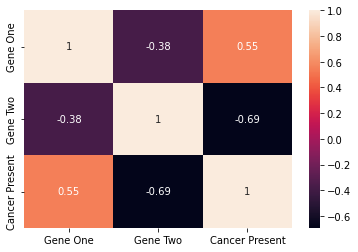

In [6]:
sns.heatmap(df.corr(), annot=True)

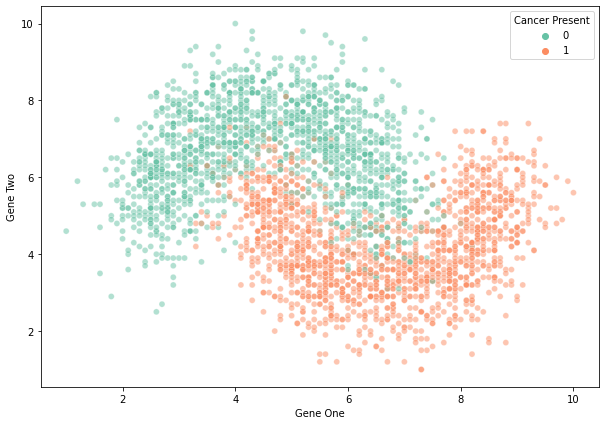

In [7]:
plt.figure(figsize=(10,7))

sns.scatterplot(data=df, x='Gene One', y='Gene Two', hue='Cancer Present', alpha=0.5, palette='Set2');

## Model

### Train|Test Split & Scaling Data

In [8]:
X = df[['Gene One', 'Gene Two']]
y = df['Cancer Present']

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=0.3)

In [11]:
scaler = StandardScaler()
sc_X_train = scaler.fit_transform(X_train)
sc_X_test = scaler.transform(X_test)

### Creat KNN Model 

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
knn_model = KNeighborsClassifier(n_neighbors=5, p=2)

In [14]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [15]:
knn_model.fit(sc_X_train, y_train)

KNeighborsClassifier()

### Model Evaluation

In [16]:
y_pred = knn_model.predict(sc_X_test)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [18]:
accuracy_score(y_test, y_pred)

0.9355555555555556

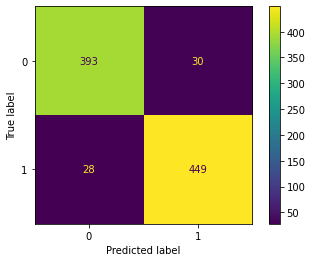

In [19]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot();

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       423
           1       0.94      0.94      0.94       477

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



# Best model selection

## • Elbow Method for Choosing Reasonable K Values

**NOTE: This uses the test set for the hyperparameter selection of K.**

In [21]:
test_errors = []

for i in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(sc_X_train, y_train)
    y_pred = knn_model.predict(sc_X_test)
    
    err = 1 - accuracy_score(y_test, y_pred)
    test_errors.append(err)

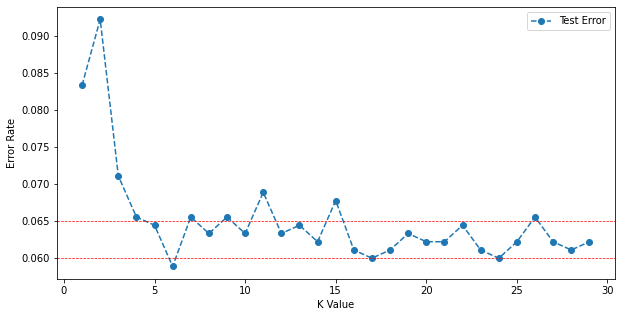

In [22]:
plt.figure(figsize=(10,5))
plt.plot(range(1,30),test_errors,'--o',label='Test Error')

plt.axhline(y=0.065, color='red', ls='--', lw=0.7)
plt.axhline(y=0.060, color='red', ls='--', lw=0.7)

plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("K Value");

## • Full CV Grid Search for K values

### Creating a Pipeline to find K value

**Note: You must be extra careful about using Pipeline!**

We use Pipeline to:

    1. Scale Data
    2. Create a model on Scaled Data
    
Pipeline will be so smart enough to *scale and train on Training data* and *transform on Test data*. We just need to pass the Scaler and desired model to pipeline.

We consider these steps:
    
    0: The data must be split into Train and Test data 
    1: The scaler is fitted on the Train Data
    2: The scaler transforms Train Data
    3: The Model is fitted/trained on Train Data
    4: The scaler transforms Test Data
    5: The trained-model predicts the Transformed-Test Data

In [23]:
from sklearn.pipeline import Pipeline

In [24]:
# Operations of the pipeline

operation = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]

In [25]:
# Chenk the model parameters 

KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [26]:
# Create  pipeline

pipe = Pipeline(operation)

For choosing the parameters in a Pipeline we must be careful about the name of the operations and follow these rules:

    • ChosenStringName + __ + ParameterKeyName
    • e.g. 'knn__p' , 'knn__n_neighbors'

In [27]:
# choose desired parameters of the model 

params = {
    'knn__n_neighbors' : list(range(1,16)),
    'knn__p' : [2]
}

In [28]:
# GridSearchCV 

from sklearn.model_selection import GridSearchCV

full_cv = GridSearchCV(estimator=pipe, param_grid=params, cv=5, scoring='accuracy')

In [29]:
full_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15],
                         'knn__p': [2]},
             scoring='accuracy')

In [30]:
full_cv.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=13))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=13),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 13,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [31]:
pd.DataFrame(full_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002992,1.907349e-07,0.009973,3.504023e-07,1,2,"{'knn__n_neighbors': 1, 'knn__p': 2}",0.907143,0.878571,0.897619,0.892857,0.907143,0.896667,0.010605,15
1,0.003192,3.990174e-04,0.009774,3.988266e-04,2,2,"{'knn__n_neighbors': 2, 'knn__p': 2}",0.902381,0.895238,0.911905,0.909524,0.897619,0.903333,0.006494,14
2,0.003203,3.937455e-04,0.009164,4.048104e-04,3,2,"{'knn__n_neighbors': 3, 'knn__p': 2}",0.926190,0.909524,0.919048,0.914286,0.916667,0.917143,0.005512,13
3,0.002990,6.177572e-06,0.010246,1.081723e-03,4,2,"{'knn__n_neighbors': 4, 'knn__p': 2}",0.930952,0.909524,0.926190,0.911905,0.909524,0.917619,0.009110,12
4,0.002796,4.010507e-04,0.009569,8.044387e-04,5,2,"{'knn__n_neighbors': 5, 'knn__p': 2}",0.923810,0.916667,0.930952,0.921429,0.928571,0.924286,0.005084,10
5,0.002982,2.284065e-05,0.009589,4.752841e-04,6,2,"{'knn__n_neighbors': 6, 'knn__p': 2}",0.928571,0.916667,0.923810,0.926190,0.921429,0.923333,0.004096,11
6,0.002496,4.461887e-04,0.009776,3.984475e-04,7,2,"{'knn__n_neighbors': 7, 'knn__p': 2}",0.928571,0.916667,0.933333,0.928571,0.926190,0.926667,0.005512,6
7,0.002992,4.572170e-06,0.009978,3.553637e-06,8,2,"{'knn__n_neighbors': 8, 'knn__p': 2}",0.926190,0.921429,0.938095,0.930952,0.919048,0.927143,0.006835,3
8,0.002993,2.102414e-06,0.011371,1.352502e-03,9,2,"{'knn__n_neighbors': 9, 'knn__p': 2}",0.926190,0.909524,0.938095,0.928571,0.930952,0.926667,0.009452,6
9,0.002992,6.309019e-04,0.010372,4.884609e-04,10,2,"{'knn__n_neighbors': 10, 'knn__p': 2}",0.926190,0.909524,0.942857,0.938095,0.919048,0.927143,0.012196,3


## Final Model


We came to the conclusion that KNN with 13 neighbours would be the best model.

In [32]:
operation = [
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13, p=2))
]

In [33]:
pipe = Pipeline(operation)

In [34]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=13))])

In [35]:
y_pred = pipe.predict(X_test)

In [36]:
### Evaluation

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       423
           1       0.93      0.95      0.94       477

    accuracy                           0.94       900
   macro avg       0.94      0.93      0.94       900
weighted avg       0.94      0.94      0.94       900



In [37]:
testdata = X.iloc[120]

In [38]:
pipe.predict(testdata.values.reshape(1, -1))

C:\Users\rafes\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [39]:
pipe.predict_proba(testdata.values.reshape(1, -1))

C:\Users\rafes\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0., 1.]])